# 9. Сравнение моделей авторегрессии и рекуррентных сетей в задаче прогнозирования стоимости валют.

In [1]:
! pip install forex_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 13.9 MB/s 


In [2]:
from datetime import datetime
from forex_python.converter import get_rate
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import numpy as np

import tensorflow as tf
import tensorflow.keras as K

## Загрузка данных стоимости валют: курс доллара в рублях, период с 31.21.2013 по 01.01.2014 на обучение, с 01.01.2014 по 01.06.2014 на тестирование.

In [3]:
#на обучение
start_date = datetime(2013, 1, 1) 
end_date = datetime(2013, 12, 31) 
res_train = pd.date_range(
    min(start_date, end_date),
    max(start_date, end_date))

#на тестирование
start_date = datetime(2013, 12, 1) 
end_date = datetime(2014, 6, 1) 
res_test = pd.date_range(
    min(start_date, end_date),
    max(start_date, end_date))

In [4]:
rates_train = []
for date in res_train:
  rates_train.append(get_rate("USD", "RUB", date))

rates_test = []
for date in res_test:
  rates_test.append(get_rate("USD", "RUB", date))

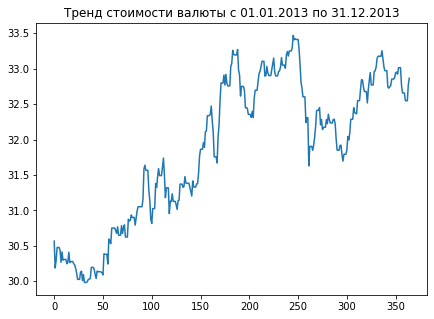

In [5]:
plt.figure(figsize = (7,5))
plt.plot(rates_train)
plt.title('Тренд стоимости валюты с 01.01.2013 по 31.12.2013')
plt.show()

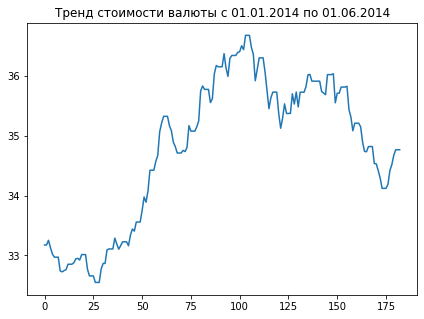

In [6]:
plt.figure(figsize = (7,5))
plt.plot(rates_test)
plt.title('Тренд стоимости валюты с 01.01.2014 по 01.06.2014')
plt.show()

## Модель авторегрессии

Модель Pure AR(только авторегрессивная) – это модель, которая полагается только на собственные лаги. Следовательно, мы также можем сделать вывод, что это функция «запаздывания Yt».

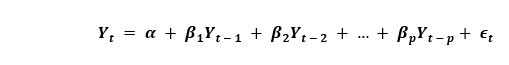


Аналогичным образом, модель Pure MA (только скользящее среднее) – это модель, в которой Yt полагается только на запаздывающие предсказанные ошибки.
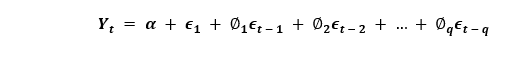

Где, ошибки – это ошибки моделей AR соответствующих лагов.

Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
1. p — порядок компоненты AR
2. d — порядок интегрированного ряда
3. q — порядок компонетны MA

In [7]:
test = sm.tsa.adfuller(rates_train)
print( 'adf: ', test[0])
print('p-value: ', test[1]) 
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print( 'единичных корней нет, ряд стационарен')

adf:  -1.2837686455021482
p-value:  0.6365650774118666
Critical values:  {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}
есть единичные корни, ряд не стационарен


In [22]:
df_train = pd.DataFrame({'rates':rates_train})
df_test = pd.DataFrame({'rates':rates_test})
df_test.index = np.arange(len(df_train)-30, len(df_train)+len(df_test)-30)

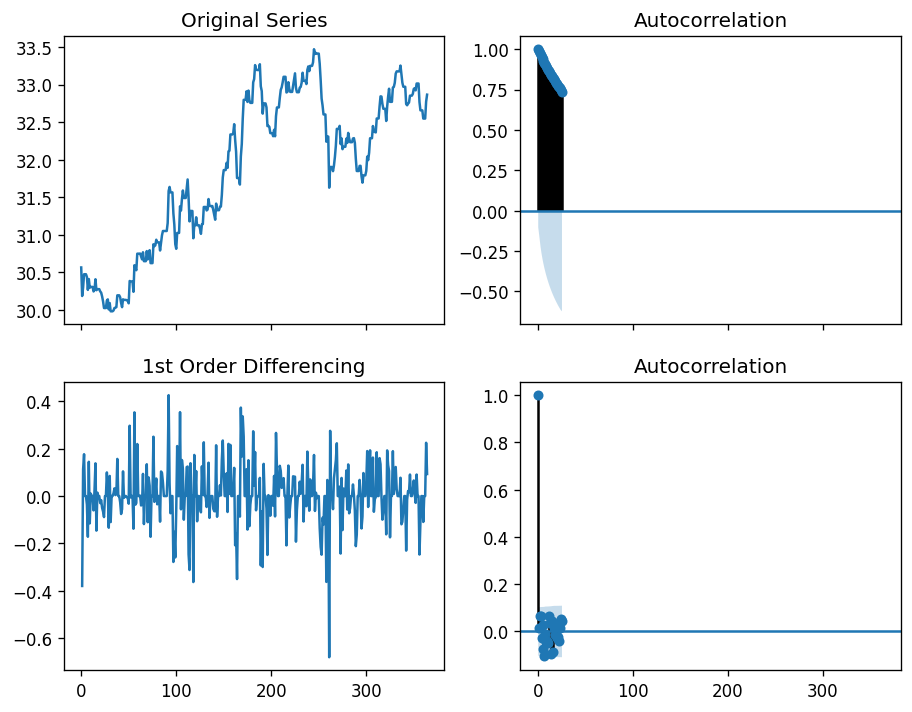

In [23]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(df_train.rates)
axes[0, 0].set_title('Original Series')
plot_acf(df_train.rates, ax=axes[0, 1], lags=25)

axes[1, 0].plot(df_train.rates.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_train.rates.diff().dropna(), ax=axes[1, 1], lags=25)
plt.show()
plt.show()

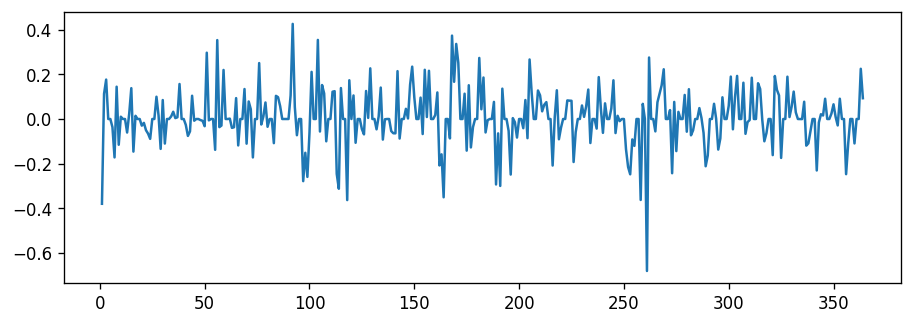

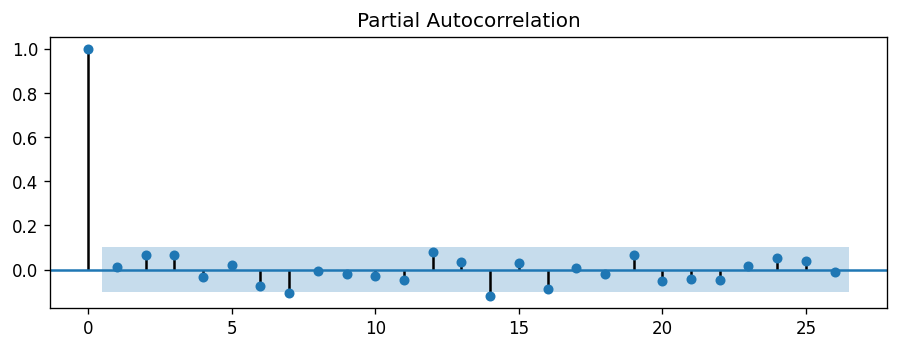

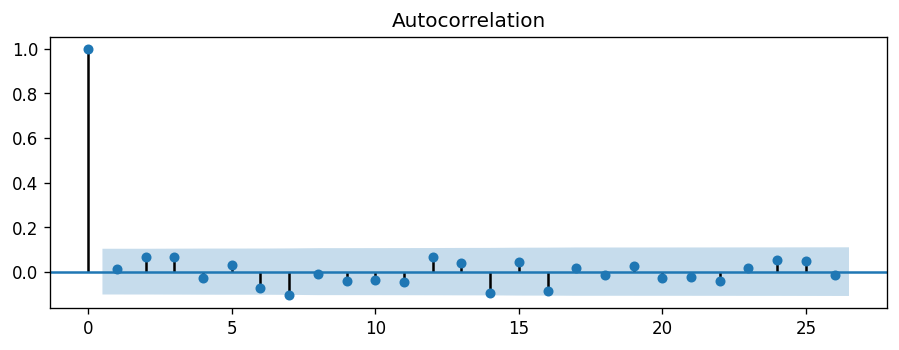

In [24]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
plt.plot(df_train.rates.diff())
plt.show()

plot_pacf(df_train.rates.diff().dropna())
plt.show()

plot_acf(df_train.rates.diff().dropna())
plt.show()

Только один лаг сильно отличен от нуля, поэтому порядок компоненты AR  p =1.
Аналогично для ACF сильно отличается от 0 первый лаг, поэтому порядок компоненты MA q = 1.

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_train.rates, order=(1,1,1))

model_fit = model.fit()

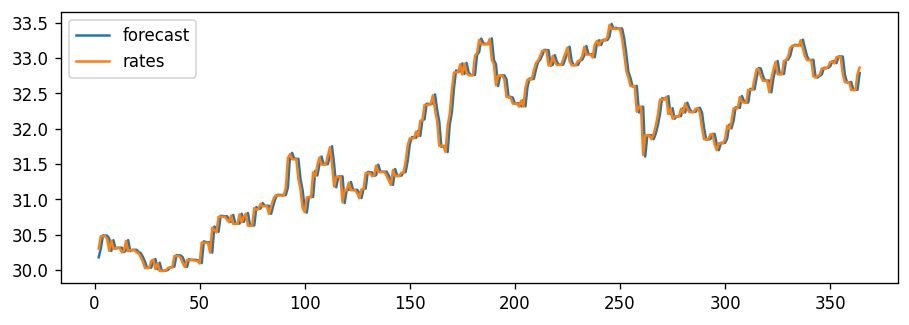

In [27]:
model_fit.plot_predict(dynamic=False)
plt.show()

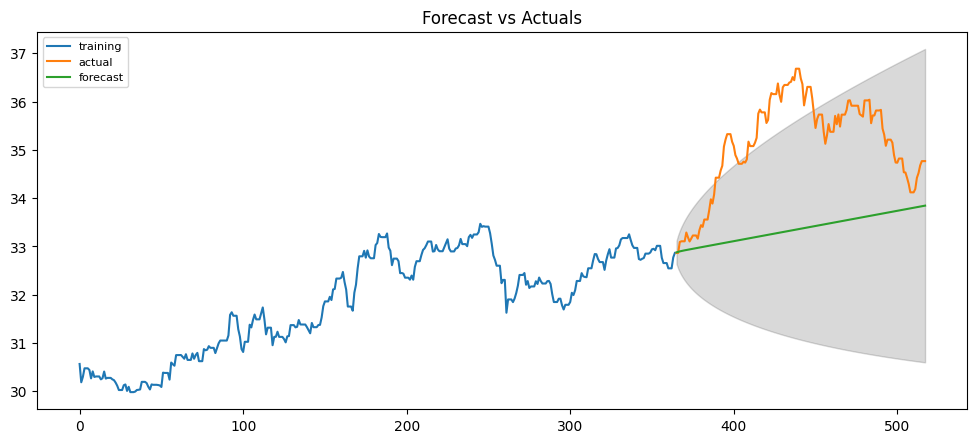

In [32]:
fc, se, conf = model_fit.forecast(len(df_test)-30, alpha=0.05) 

fc_series = pd.Series(fc, index=df_test.index[30:])
lower_series = pd.Series(conf[:, 0], index=df_test.index[30:])
upper_series = pd.Series(conf[:, 1], index=df_test.index[30:])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test[30:], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
mse = tf.keras.losses.MeanSquaredError()
mse(df_test, fc_series).numpy()

3.5578810465123563

# Рекурентные нейронные сети

In [34]:
def data_gen():
    for i in range(N-ws):
        x = s[i:i+ws].reshape(-1,1)
        y = s[i+ws].reshape(1)
        yield x, y

In [35]:
N = len(rates_train)
ws = 30
s = np.array(rates_train)
dgen = data_gen()

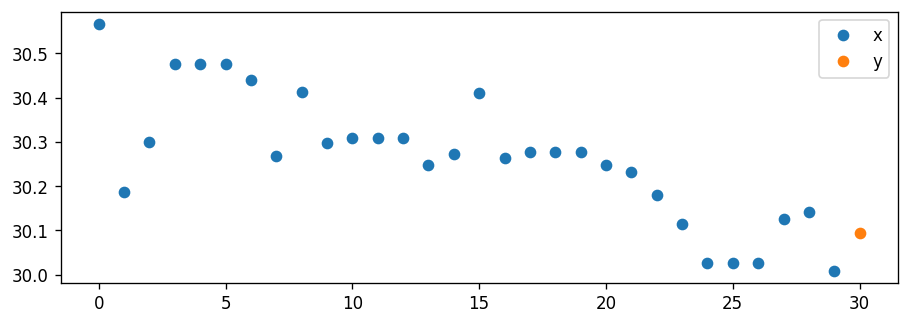

In [36]:
x, y = next(dgen)
plt.plot(range(ws), x, 'o')
plt.plot(ws, y, 'o')
plt.legend(['x', 'y'])

In [37]:
rates_train = np.array(rates_train)
N1 = len(rates_train)
ws = 30
X_train  = [rates_train[i:i+ws].reshape(-1,1) for i in range(N1-ws)]
y_train = [rates_train[i+ws].reshape(1) for i in range(N1-ws)]

In [38]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [39]:
N2 = len(rates_test)
rates_test = np.array(rates_test)
X_test  = [rates_test[i:i+ws].reshape(-1,1) for i in range(N2-ws)]
y_test = [rates_test[i+ws].reshape(1) for i in range(N2-ws)]

In [40]:
X_test = np.array(X_test)
y_test = np.array(y_test)

## RNN

Полностью подключенный RNN, где выход должен подаваться обратно на вход. Cлой RNN использует цикл for для итерации по упорядоченной по времени последовательности, храня при этом во внутреннем состоянии, закодированную информацию о шагах, которые он уже видел

units = размерность выходного пространства.

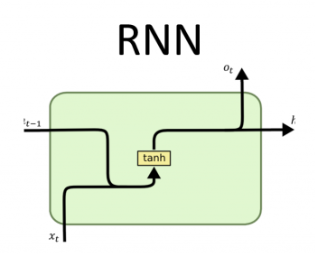

In [75]:
model = K.Sequential([
        K.layers.InputLayer((ws, 1)),
        K.layers.SimpleRNN(128),
        K.layers.Dense(16, activation = 'relu'), 
        K.layers.Dense(1)
    ])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 128)               16640     
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 18,721
Trainable params: 18,721
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(optimizer='rmsprop',
              loss='mse')

history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
11/11 [==============================] - 1s 19ms/step - loss: 949.6677
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 821.7828
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 729.2368
Epoch 4/100
11/11 [==============================] - 0s 22ms/step - loss: 622.8588
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 540.4528
Epoch 6/100
11/11 [==============================] - 0s 19ms/step - loss: 466.7691
Epoch 7/100
11/11 [==============================] - 0s 17ms/step - loss: 398.4677
Epoch 8/100
11/11 [==============================] - 0s 21ms/step - loss: 333.3832
Epoch 9/100
11/11 [==============================] - 0s 20ms/step - loss: 272.0101
Epoch 10/100
11/11 [==============================] - 0s 20ms/step - loss: 215.2036
Epoch 11/100
11/11 [==============================] - 0s 19ms/step - loss: 163.8411
Epoch 12/100
11/11 [==============================] - 0s 19ms/step - loss: 118.6141
E

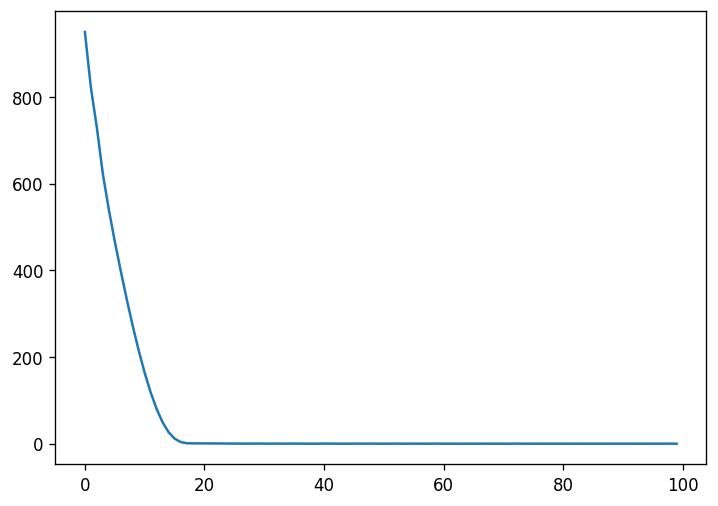

In [77]:
plt.figure(figsize = (7,5))
plt.plot(history.history['loss'])

In [78]:
y_ = model.predict(X_train)

11/11 [==============================] - 0s 4ms/step


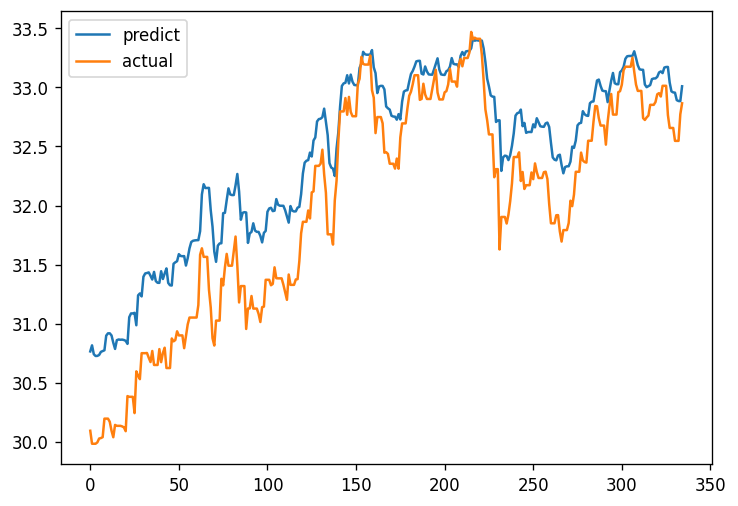

In [79]:
plt.figure(figsize = (7,5))
plt.plot(y_)
plt.plot(y_train)
plt.legend(['predict', 'actual'])

In [80]:
y_ = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


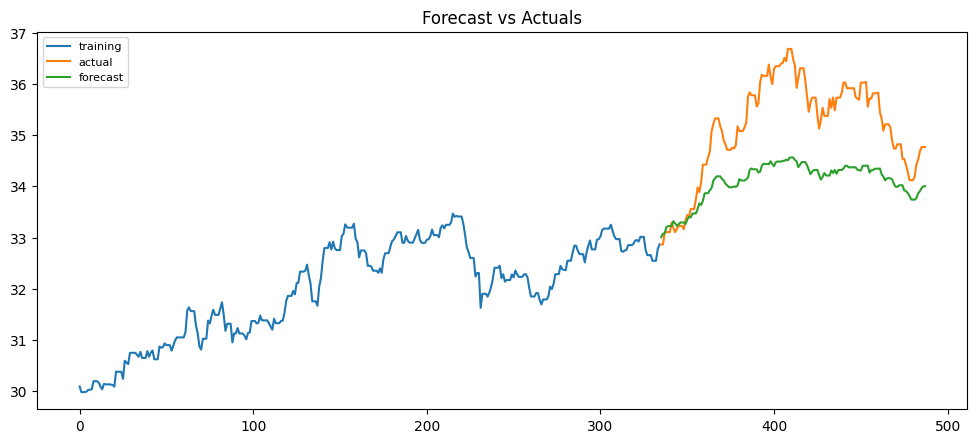

In [81]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(range(N1-ws), y_train, label='training')
plt.plot(range(N1-ws,N1+N2-2*ws),y_test, label='actual')
plt.plot(range(N1-ws,N1+N2-2*ws),y_, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [82]:
mse(y_test, y_).numpy()

1.4924002

## LSTM

Долгая краткосрочная память (Long short-term memory; LSTM) – особая разновидность архитектуры рекуррентных нейронных сетей, способная к обучению долговременным зависимостям. 

Первый шаг в LSTM – определить, какую информацию можно выбросить из состояния ячейки. Это решение принимает сигмоидальный слой, называемый “слоем фильтра забывания” (forget gate layer). Он смотрит на $h_{t-1}$ и $x_t$ и возвращает число от 0 до 1 для каждого числа из состояния ячейки $C_{t-1}$. 1 означает “полностью сохранить”, а 0 – “полностью выбросить”.

Следующий шаг – решить, какая новая информация будет храниться в состоянии ячейки. Этот этап состоит из двух частей. Сначала сигмоидальный слой под названием “слой входного фильтра” (input layer gate) определяет, какие значения следует обновить. Затем tanh-слой строит вектор новых значений-кандидатов $\tilde{C}_t$, которые можно добавить в состояние ячейки

Настало время заменить старое состояние ячейки $C_{t-1}$ на новое состояние $C_t$. Что нам нужно делать — мы уже решили на предыдущих шагах, остается только выполнить это.

Мы умножаем старое состояние на $f_t$, забывая то, что мы решили забыть. Затем прибавляем $i_t*\tilde{C}_t$. Это новые значения-кандидаты, умноженные на $t$ – на сколько мы хотим обновить каждое из значений состояния.

Наконец, нужно решить, какую информацию мы хотим получать на выходе. Выходные данные будут основаны на нашем состоянии ячейки, к ним будут применены некоторые фильтры. Сначала мы применяем сигмоидальный слой, который решает, какую информацию из состояния ячейки мы будем выводить. Затем значения состояния ячейки проходят через tanh-слой, чтобы получить на выходе значения из диапазона от -1 до 1, и перемножаются с выходными значениями сигмоидального слоя, что позволяет выводить только требуемую информацию.


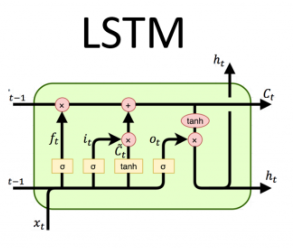

In [65]:
model = K.Sequential([
        K.layers.InputLayer((ws, 1)),
        K.layers.LSTM(8),
        K.layers.Dense(200, activation = 'relu'), 
        K.layers.Dense(1)
    ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 200)               1800      
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,321
Trainable params: 2,321
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(optimizer='adam',
              loss='mse')

history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
11/11 [==============================] - 4s 5ms/step - loss: 1014.5505
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 981.1813
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 946.9929
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 909.7090
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 866.6253
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 814.5925
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 751.5820
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 676.4156
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 586.2548
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 472.1363
Epoch 11/100
11/11 [==============================] - 0s 4ms/step - loss: 337.2914
Epoch 12/100
11/11 [==============================] - 0s 4ms/step - loss: 221.7882
Epoch 13/100

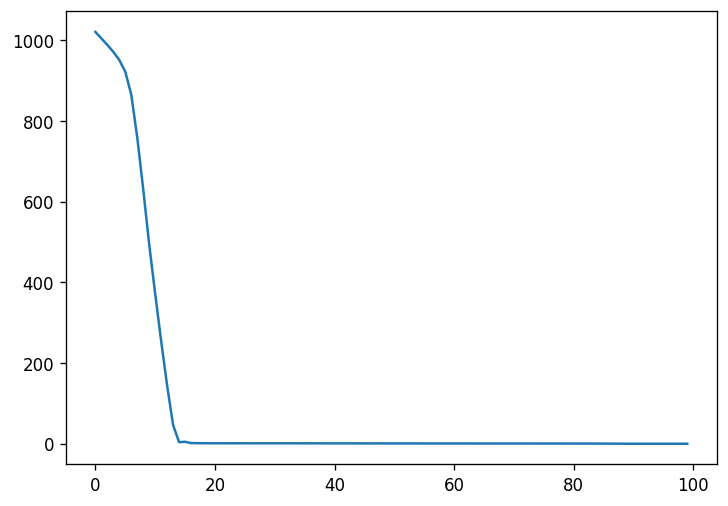

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(history.history['loss'])

In [ ]:
y_ = model.predict(X_train)

11/11 [==============================] - 0s 2ms/step


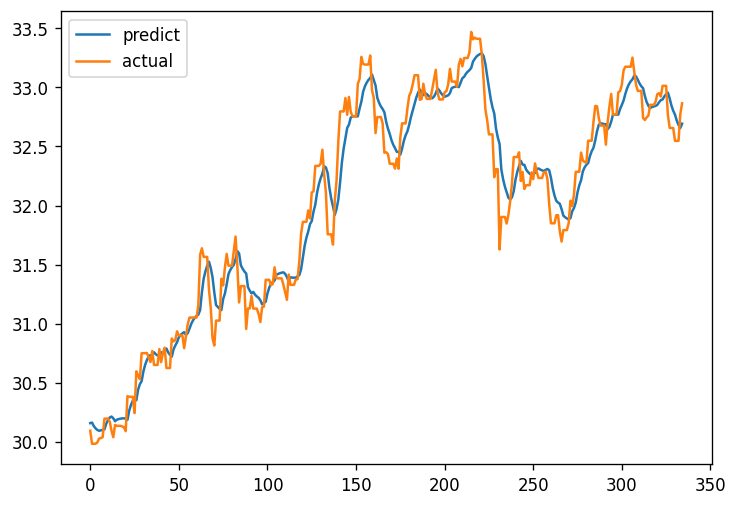

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(y_)
plt.plot(y_train)
plt.legend(['predict', 'actual'])

In [ ]:
y_ = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


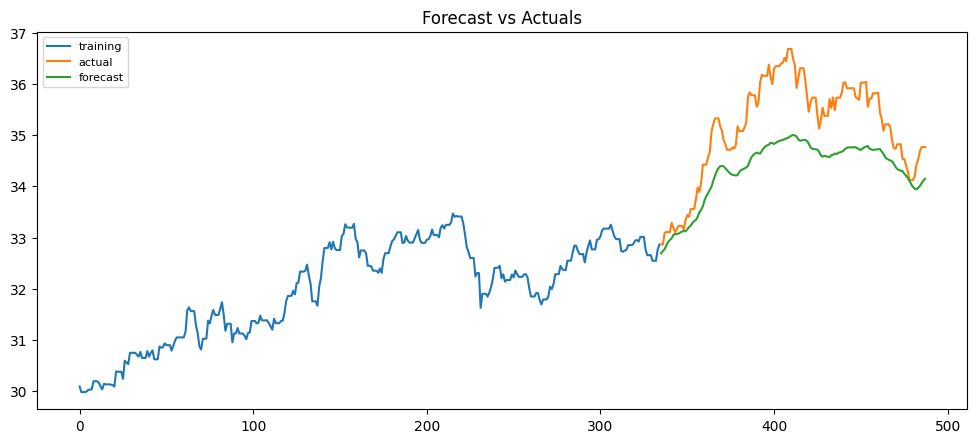

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(range(N1-ws), y_train, label='training')
plt.plot(range(N1-ws,N1+N2-2*ws),y_test, label='actual')
plt.plot(range(N1-ws,N1+N2-2*ws),y_, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
mse(y_test, y_).numpy()

0.87450683

## GRU

GRU - это новое поколение рекуррентных нейронных сетей, очень похожее на LSTM. ГРУ избавился от состояния ячейки и использовал скрытое состояние для передачи информации. Он также имеет только два шлюза, ворота сброса и ворота обновления.

Шлюз обновления действует аналогично шлюзу забытия и ввода LSTM. Он решает, какую информацию выбросить и какую новую информацию добавить.

Шлюз сброса - это еще один шлюз, который используется для определения того, сколько прошлой информации нужно забыть.

И это ГРУ. ГРУ имеет меньше тензорных операций; следовательно, они немного быстрее обучаются, чем LSTM. Нет ясного победителя, какой из них лучше. Исследователи и инженеры обычно пытаются определить, какой из них лучше подходит для их случая использования.

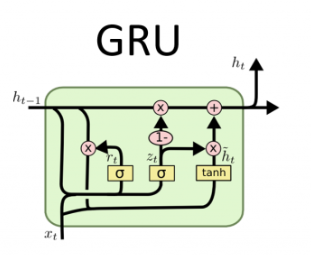

In [91]:
model = K.Sequential([
        K.layers.InputLayer((ws, 1)),
        K.layers.GRU(8),
        K.layers.Dense(200, activation = 'relu'), 
        K.layers.Dense(1)
    ])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 8)                 264       
                                                                 
 dense_14 (Dense)            (None, 200)               1800      
                                                                 
 dense_15 (Dense)            (None, 1)                 201       
                                                                 
Total params: 2,265
Trainable params: 2,265
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer='rmsprop',
              loss='mse')

history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
11/11 [==============================] - 2s 5ms/step - loss: 989.5029
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 937.7534
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 880.2734
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 816.2624
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 749.4805
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 680.5203
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 607.9188
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 528.8450
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 441.9346
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 349.0557
Epoch 11/100
11/11 [==============================] - 0s 4ms/step - loss: 255.7519
Epoch 12/100
11/11 [==============================] - 0s 5ms/step - loss: 171.0619
Epoch 13/100


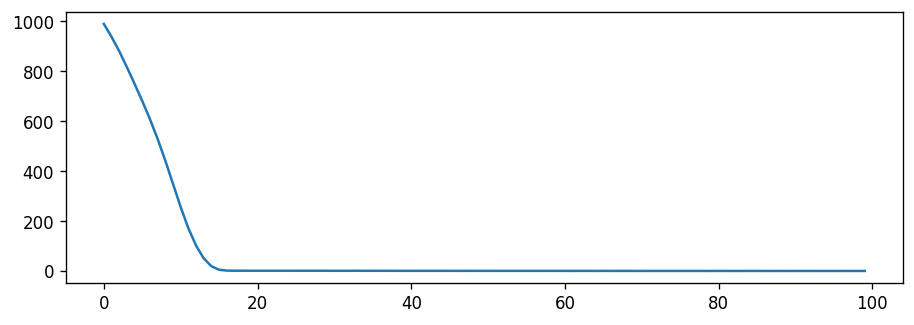

In [93]:
plt.plot(history.history['loss'])

In [94]:
y_ = model.predict(X_train)

11/11 [==============================] - 0s 2ms/step


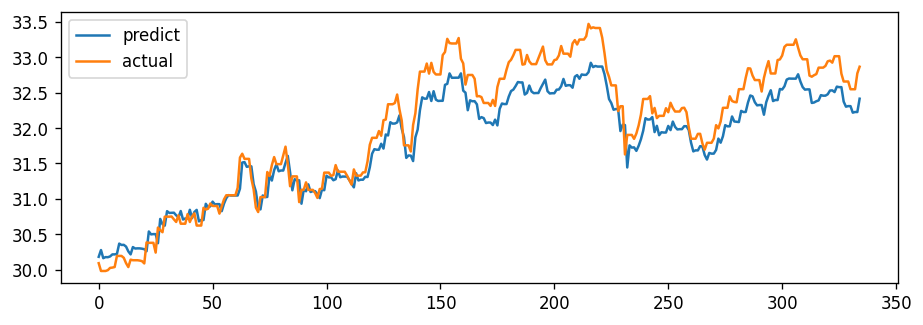

In [95]:
plt.plot(y_)
plt.plot(y_train)
plt.legend(['predict', 'actual'])

In [96]:
y_ = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


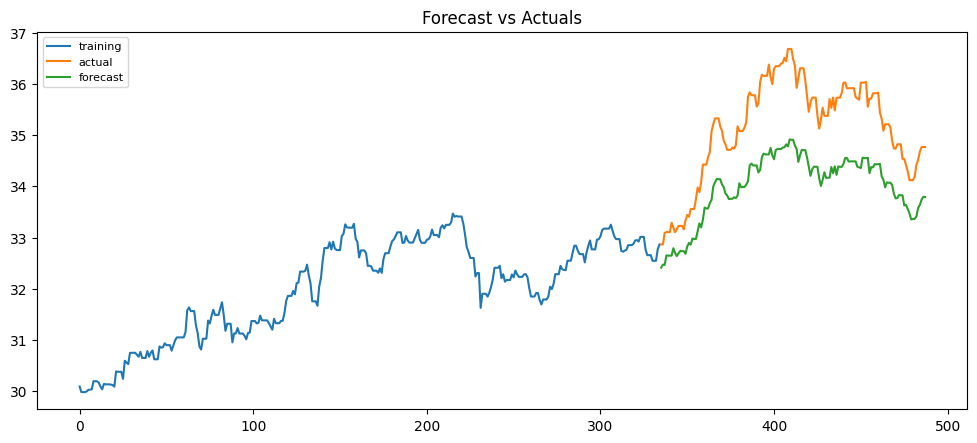

In [97]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(range(N1-ws), y_train, label='training')
plt.plot(range(N1-ws,N1+N2-2*ws),y_test, label='actual')
plt.plot(range(N1-ws,N1+N2-2*ws),y_, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [98]:
mse(y_test, y_).numpy()

1.4598014

# Bidirectional

В целом, их архитектура достаточно проста и представлена двумя рекуррентными слоями, разворачивающихся в противоположных направлениях

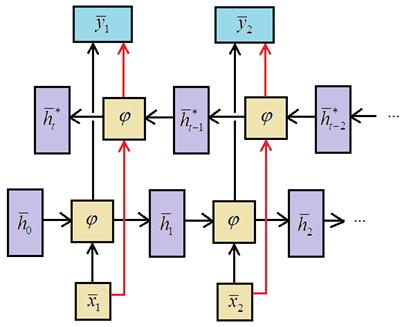

Двунаправленные рекуррентные нейронные сети (RNN) действительно просто объединяют две независимые RNN. Входная последовательность подается в обычном порядке времени для одной сети и в обратном порядке времени для другой. Выходы двух сетей обычно объединяются на каждом временном шаге, хотя есть и другие варианты, например, суммирование.

In [ ]:
model = K.Sequential([
        K.layers.InputLayer((ws, 1)),
        K.layers.Bidirectional(K.layers.LSTM(4)),
        K.layers.Dense(200, activation = 'relu'), 
        K.layers.Dense(1)
    ])

model.summary()

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_25 (Bidirecti  (None, 8)                192       
 onal)                                                           
                                                                 
 dense_202 (Dense)           (None, 200)               1800      
                                                                 
 dense_203 (Dense)           (None, 1)                 201       
                                                                 
Total params: 2,193
Trainable params: 2,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='mse')

history = model.fit(X_train, y_train, epochs=150)

Epoch 1/150
11/11 [==============================] - 3s 7ms/step - loss: 1018.0848
Epoch 2/150
11/11 [==============================] - 0s 6ms/step - loss: 1001.1528
Epoch 3/150
11/11 [==============================] - 0s 6ms/step - loss: 983.0620
Epoch 4/150
11/11 [==============================] - 0s 9ms/step - loss: 961.5966
Epoch 5/150
11/11 [==============================] - 0s 7ms/step - loss: 930.6481
Epoch 6/150
11/11 [==============================] - 0s 6ms/step - loss: 881.6273
Epoch 7/150
11/11 [==============================] - 0s 7ms/step - loss: 826.1655
Epoch 8/150
11/11 [==============================] - 0s 6ms/step - loss: 764.1734
Epoch 9/150
11/11 [==============================] - 0s 7ms/step - loss: 678.0755
Epoch 10/150
11/11 [==============================] - 0s 7ms/step - loss: 543.6708
Epoch 11/150
11/11 [==============================] - 0s 7ms/step - loss: 378.5116
Epoch 12/150
11/11 [==============================] - 0s 7ms/step - loss: 251.3556
Epoch 13/15

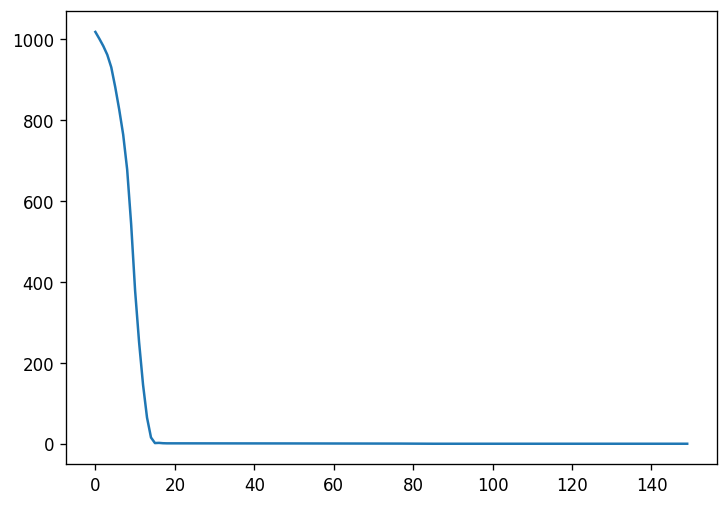

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(history.history['loss'])

In [ ]:
y_ = model.predict(X_train)

11/11 [==============================] - 1s 3ms/step


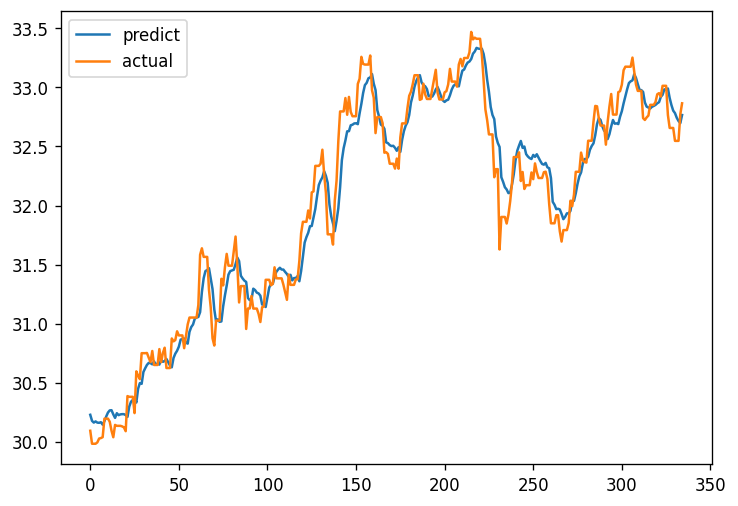

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(y_)
plt.plot(y_train)
plt.legend(['predict', 'actual'])

In [ ]:
y_ = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


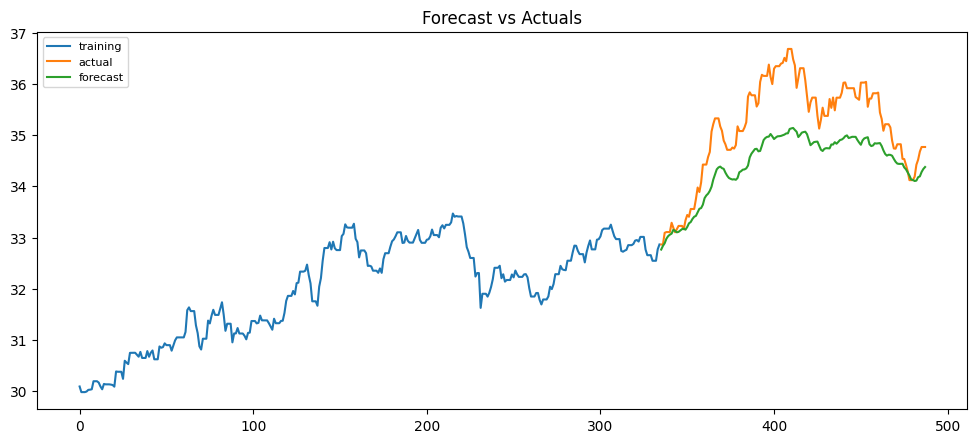

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(range(N1-ws), y_train, label='training')
plt.plot(range(N1-ws,N1+N2-2*ws),y_test, label='actual')
plt.plot(range(N1-ws,N1+N2-2*ws),y_, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
mse(y_test, y_).numpy()

0.71081495

## Результаты:
Модель ARIMA показала отличный результат на тренировке и самый худший результат на тестовой выборке по метрике MSE: 3.55

Модель с простыми рекурентными слоями RNN показала хороший результат на тренировке и тесте: 1.492

Модель с LSTM слоем показала отличный результата на тренировке и второй по качеству результат на тесте: 0.874

Модель с GRU слоем показалаезультат лучше в сравнении с RNN и ARIMA, но достичь уровня LSTM не удалось: 1.459

Самая лучшая модель оказалась двунаправленная модель со слоем LSTM:0.7108. Однако применение двунаправленных сетей к временным рядом не уместно, поскольку будущие значения для нас в реальном времени остаются не известными.